Use case: Model data communications in a large network 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import warnings
import matplotlib.pyplot as plt
import random
from itertools import cycle
import torch
from torch.autograd import Variable
import pymc3 as pm
from arviz import plot_trace
from scipy import stats

In [16]:
warnings.filterwarnings("ignore")
pd.set_option("max_columns", 80)

In [17]:
plt.style.use("bmh")
color_loop = plt.rcParams['axes.prop_cycle'].by_key()["color"]
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [11]:
df = pd.read_csv('./data/element_arrivals.csv', index_col='STIME', parse_dates=['STIME'])

In [12]:
df.head()

,element-A
STIME,
2019-02-11 00:00:00,18.0
2019-02-11 00:15:00,19.0
2019-02-11 00:30:00,16.0
2019-02-11 00:45:00,14.0
2019-02-11 01:00:00,11.0


### Data arrival rate analysis

There are several ways in the data can be analyzed to identify the underlying distributions.

* Single arrival rate

* Multiple system states and arrival rate per state

* Variable arrival rate as function of time

#### Single arrival rate analysis

When analyzing the arrivals with the assumption that a single arrival rate can fit the data we can approach the problem using:

* Maximum Likelihood to identify the point estimate of the arival rate
* Bayesian intference to identify the distribution of arrival rate
* Goodness of fit tests

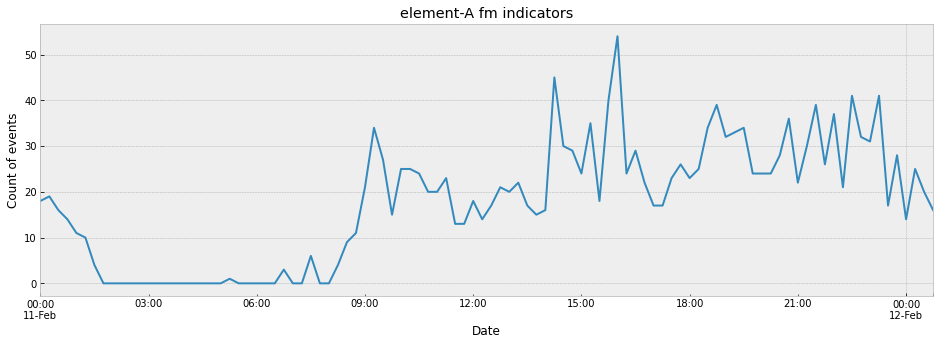

In [48]:
data = df.loc[:, 'element-A'][0:100]
#data = df_c.loc[:, 'MRBTS-817529']
plt.figure(figsize=(16,5))
data.plot(kind='line', title= '{} fm indicators'.format(data.name), lw=2, 
                   color=next(color_cycle))
plt.xlabel('Date')
plt.ylabel('Count of events')
plt.show()

### Using MLE inference 

The log likelihood of $\lambda$ given the $Data$  is: 

$$ l(\lambda; x_1, x_2, ..x_n) = n\ln(\lambda) - \lambda \sum \limits _{j=1} ^{n} x_j$$

Using pytorch to get the point estimate of $\lambda$

In [28]:
x = Variable(torch.from_numpy(data.to_numpy())).type(torch.FloatTensor)
p = Variable(torch.rand(1), requires_grad=True)
epoch = 20000
learning_rate = 0.0000025
for t in range(epoch):
    NLL = - (x.size()[0] * torch.log(p) - p * torch.sum(x))
    NLL.backward()
    
    if t % 5000 == 0:
        print("loglik  =", NLL.data.numpy(), "p =", p.data.numpy(), "dL/dp = ", p.grad.data.numpy())
        
    p.data -= learning_rate * p.grad.data
    p.grad.data.zero_()
print ("Arrival rate {}".format(1/float(p)))

loglik  = [659.45166] p = [0.30453855] dL/dp =  [1446.6343]
loglik  = [387.63855] p = [0.05633805] dL/dp =  [0.00073242]
loglik  = [387.63855] p = [0.05633805] dL/dp =  [0.00073242]
loglik  = [387.63855] p = [0.05633805] dL/dp =  [0.00073242]
Arrival rate 17.749992114728094


###  Bayesian inference

Indicators data is 'count' data of arrivals and Poisson process is very appropriate for this kind of data. Under the assumption that thi is a single rate of arrival process we have a $\text{Poisson}(\lambda)$ process where $\lambda$ is the rate of arrivals also known as the intensity of the process.
PyMC3 provides useful tooling to validate this assumption with the data. 

So in our model,

$$ {D_t} \sim \text{Poisson}(\lambda) $$

Where $D_t$ is the data count in time interval $t$. We are interetsed in inferring $\lambda$ from the data. ${lambda}$ can be any positive number. And, the exponential distribution provides a continuous density function for positive numbers, so it can be a good choice for modeling Poisson process rate ${\lambda}$. We can model this exponential as

$$ \lambda \sim  exp(\alpha) $$

Where $\alpha$ is the parameter describing the exponential distribution. This is a hyper-parameter for the model that we will build.
Below is the implementation of this model using PyMC3 and fit the data to get the postier probabilites of the paranmeter $\lambda$ given the data.

Examples on how to use PyMC3 for such modelling creation to generate the posterior probabilities are here:  
[Examples:1](https://docs.pymc.io/notebooks/getting_started.html?highlight=disaster)
[Examples:2](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [rate]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.


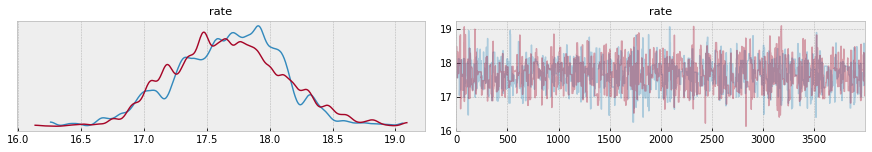

In [29]:
with pm.Model() as alarm_model:
    expectation = pm.Exponential('rate', lam=0.5)
    disasters = pm.Poisson('alarm', expectation, observed=data)
with alarm_model:
    trace = pm.sample(4000, step=[pm.Metropolis()])
    plot_trace(trace, ['rate'])

#####  NOTE : If the MCMC is able to fit the data is a reasonable indicator that the prior is reasonabaly valid.

Here, instead of point estimates of the rate of arrival we are able to get a full posterier probability distribution of rate

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [variance_arrival_rate]
>Metropolis: [mean_arrival_rate]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.


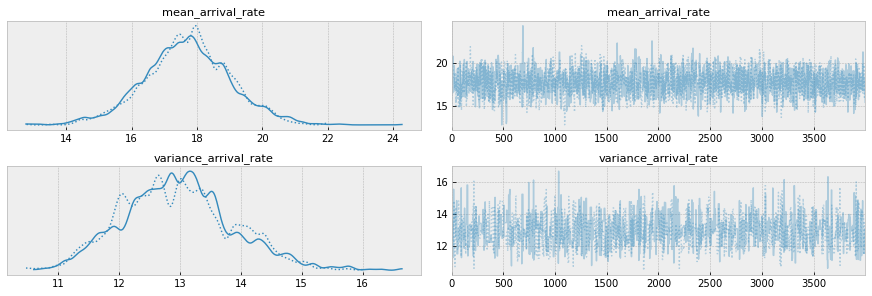

In [30]:
with pm.Model() as alarm_model:
    mu_a = pm.Normal('mean_arrival_rate', mu=0., sigma=100)
    sigma_a = pm.HalfNormal('variance_arrival_rate', 5.)
    arrival_rate = pm.Normal('arrival_dist', mu=mu_a, sigma=sigma_a, observed=data)
with alarm_model:
    trace = pm.sample(4000, step=[pm.Metropolis()])
    pm.traceplot(trace,
             var_names=['mean_arrival_rate', 'variance_arrival_rate']);

## Multi rate analysis
 
Lets build a model which is described by two rates instead of one,

$$ {D_t} \sim \text{Poisson}(\lambda) $$

Where $D_t$ is the data count in time interval $t$. Now we model the process has having a rate $\lambda_1$ and at a point in time $\tau$ the rate changes to $\lambda_2$. So 

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

 

We are interetsed in inferring $\lambda$ from the data. ${lambda}$ can be any positive number. And, the exponential distribution provides a continuous density function for positive numbers, so it can be a good choice for modeling Poisson process rate ${\lambda}$. We can model this exponential as


$$ \lambda_1 \sim \text{Exp}( \alpha_1 )  $$
$$\lambda_2 \sim \text{Exp}( \alpha_2 ) $$


Where $(\alpha_1)$ and $(\alpha_2)$ are the parameters describing the two exponential distributions. Tgese is a hyper-parameter for the model that we will build with

Below is the implementation of this model using PyMC3 and fit the data to get the postier probabilites of the parameter $\lambda$s given the data.

In [39]:
import pymc3 as pm
import theano.tensor as tt

count = len(data)
with pm.Model() as model:
    alpha = 1.0/data.mean()  
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", 2)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=count - 1)
    
with model:
    idx = np.arange(count) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [40]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=data)

In [41]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=[pm.Metropolis(), pm.NUTS()])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [tau]
>>Metropolis: [lambda_2]
>>Metropolis: [lambda_1]
>NUTS: [lambda_2, lambda_1]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 57 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [42]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

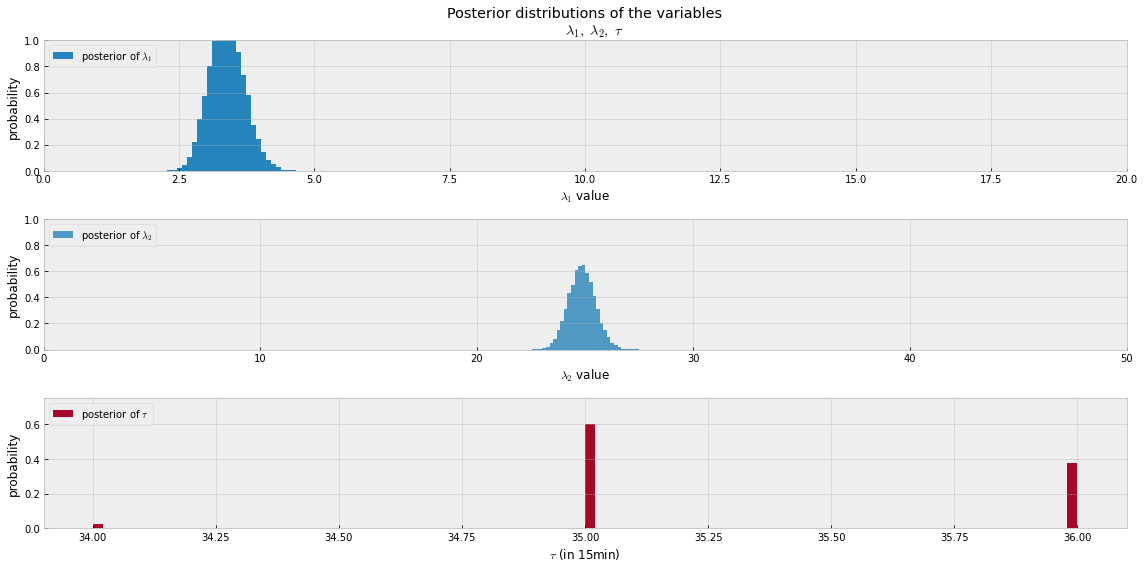

In [43]:
plt.figure(figsize=(16,8))
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color=next(color_cycle), density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([0, 20])
plt.ylabel("probability");
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color=next(color_cycle), density=True)
plt.legend(loc="upper left")
plt.xlim([0, 50])
plt.ylabel("probability");
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=count, alpha=1,
         label=r"posterior of $\tau$", color=next(color_cycle), weights=w, rwidth=2.)
#plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
#plt.xlim([35, len(data)-20])
plt.xlabel(r"$\tau$ (in 15min)")
plt.ylabel("probability");
plt.tight_layout()

### Model checking

But, ***how do we know this model is any good?***

One way to do this is to perform **posterior predictive checks**. This involves generating simulated data using the model that you built, and comparing that data to the observed data.

We can do this visually

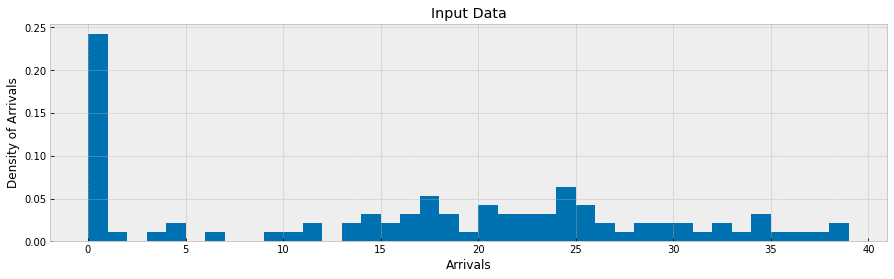

In [47]:
fig, axs = plt.subplots(1, 1, figsize=(15, 4))

a = np.arange(40)
poi = stats.poisson
lambda_ = [17.74999] # For example 1 

rate_color = next(color_cycle)
data_color = next(color_cycle)
axs.hist(data, bins=a, density=True, label='Data', color=data_color)
axs.set_ylabel("Density of Arrivals")
axs.set_xlabel("Arrivals")
axs.set_title("Input Data");